# RQ2 Analysis (performance)

## Summary

### Summary of the results

In [68]:
import pandas as pd 
import glob

# Load valid metamodels
valid_df = pd.read_csv('../results/RQ1/valid_metamodels.csv')

# Find all metamodels_run_*.csv files
run_files = glob.glob('../results/RQ2/metamodels_run_*.csv')

dfs_ = []
for f in run_files:
    df = pd.read_csv(f)
    dfs_.append(df)

# Combine all run files into a single DataFrame
runs_df_ = pd.concat([pd.read_csv(f) for f in run_files], ignore_index=True)

# Merge with valid_df on 'model' column (inner join keeps only valid metamodels)
combined_df_ = pd.merge(runs_df_, valid_df, on='model', suffixes=('_run', '_model'))

all_times_ = []
all_mem_ = []
for file in run_files:
    df = pd.read_csv(file)
    all_times_.extend(df['time'].values)
    all_mem_.extend(df['mem'].values)

all_times_ = pd.Series(all_times_)
print(f"Number of runs analyzed: {len(run_files)}")
print(f"Min time: {all_times_.min():.2f} ms")
print(f"Max time: {all_times_.max():.2f} ms")
print(f"Avg time: {all_times_.mean():.2f} ms")

all_mem_ = pd.Series(all_mem_) 
print(f"Min memory: {all_mem_.min():.2f} KB")
print(f"Max memory: {all_mem_.max():.2f} KB")
print(f"Avg memory: {all_mem_.mean():.2f} KB")

Number of runs analyzed: 30
Min time: 3.00 ms
Max time: 2726.00 ms
Avg time: 13.63 ms
Min memory: 151.00 KB
Max memory: 45979.00 KB
Avg memory: 850.88 KB


In [69]:
import pandas as pd  

dfs = [pd.read_csv(f) for f in run_files]
all_runs = pd.concat(dfs, ignore_index=True)

# Group by 'model' and compute the mean for each metric
avg_df = all_runs.groupby('model', as_index=False).mean(numeric_only=True)

# Get the top 10 models sorted by descending Mean time
avg_df = avg_df.sort_values('time', ascending=False)

avg_df.head(10)

,model,nodes,edges,time,mem
979,acad,69.0,68.0,615.666667,676.933333
1028,atm,103.0,102.0,612.766667,799.300000
1855,scheduler,57.0,56.0,605.633333,517.666667
1358,format,9514.0,12936.0,528.733333,44147.966667
1884,sgraph,63.0,108.0,421.666667,753.166667
107,CIM15,4371.0,7722.0,279.300000,18488.433333
392,IFC2X4_RC3,5117.0,7391.0,251.333333,13715.633333
1455,ifc2x3,4487.0,6350.0,228.666667,12006.733333
1456,ifc2x3tc1,4497.0,6369.0,227.966667,17374.033333
391,IFC2X3_TC1,3351.0,5223.0,175.033333,14099.866667


## Considering Time (ms)

In [70]:
def remove_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series >= lower) & (series <= upper)]

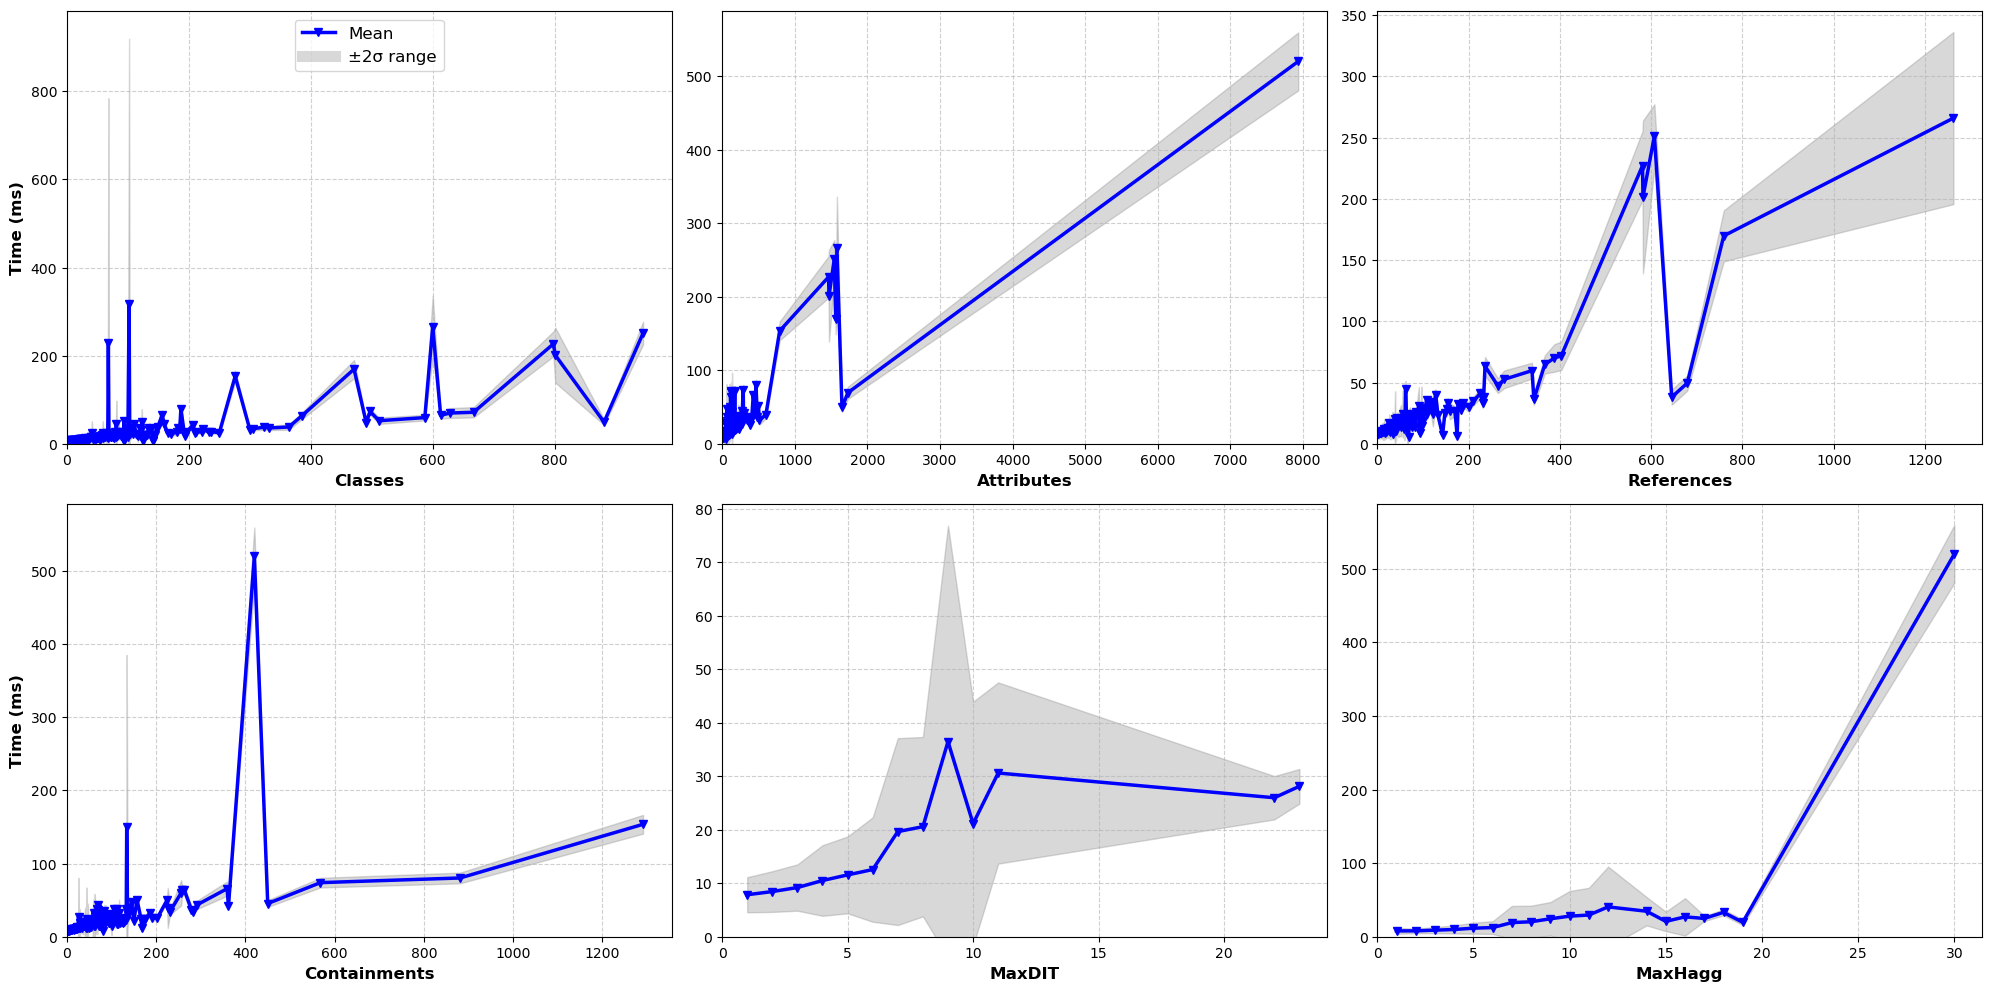

In [81]:
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import pandas as pd

for i, df in enumerate(dfs):
    df['run'] = i
runs_df = pd.concat(dfs, ignore_index=True)
combined_df = pd.merge(runs_df, valid_df, on='model', suffixes=('_run', '_model'))

props = ['classes', 'attributes', 'refs', 'containments', 'maxDIT', 'maxHagg'] 
axis_labels = {
    'classes': 'Classes',
    'attributes': 'Attributes',
    'refs': 'References',      
    'containments': 'Containments',
    'maxDIT': 'MaxDIT',       
    'maxHagg': 'MaxHagg'       
}
fig, axes = plt.subplots(2, 3, figsize=(20, 10)) 

g = 2  # number of std deviations for the band


for idx, prop in enumerate(props):
    grouped = combined_df.groupby(prop)['time']
    mean = grouped.apply(lambda s: remove_outliers(s).mean())
    std  = grouped.apply(lambda s: remove_outliers(s).std())
    lower = mean - g * std
    upper = mean + g * std
    cv = 100 * (std / mean)

    # Correct axis indexing
    ax = axes[idx // 3, idx % 3]

    # Plot mean line
    ax.plot(mean.index, mean.values, color='blue', linewidth=2.5, label='Mean', marker='v')

    # Shaded band
    ax.fill_between(mean.index, lower, upper, color='gray', alpha=0.3, label=f'±{g}σ range')

    ax.set_xlabel(axis_labels[prop], fontsize=12, fontweight='bold')
    if idx % 3 == 0:
        ax.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)

# Legend (on top-left subplot)
avg_line = mlines.Line2D([], [], color='blue', marker='v', label='Mean', linewidth=2.5)
band_patch = mlines.Line2D([], [], color='gray', linewidth=8, alpha=0.3, label=f'±{g}σ range')
axes[0, 0].legend(handles=[avg_line, band_patch], loc='upper center', fontsize=12, frameon=True)

plt.tight_layout(pad=1)
plt.savefig("img/RQ2timeavg.pdf", format='pdf', bbox_inches='tight')
plt.show()



## Considering memory (MB)

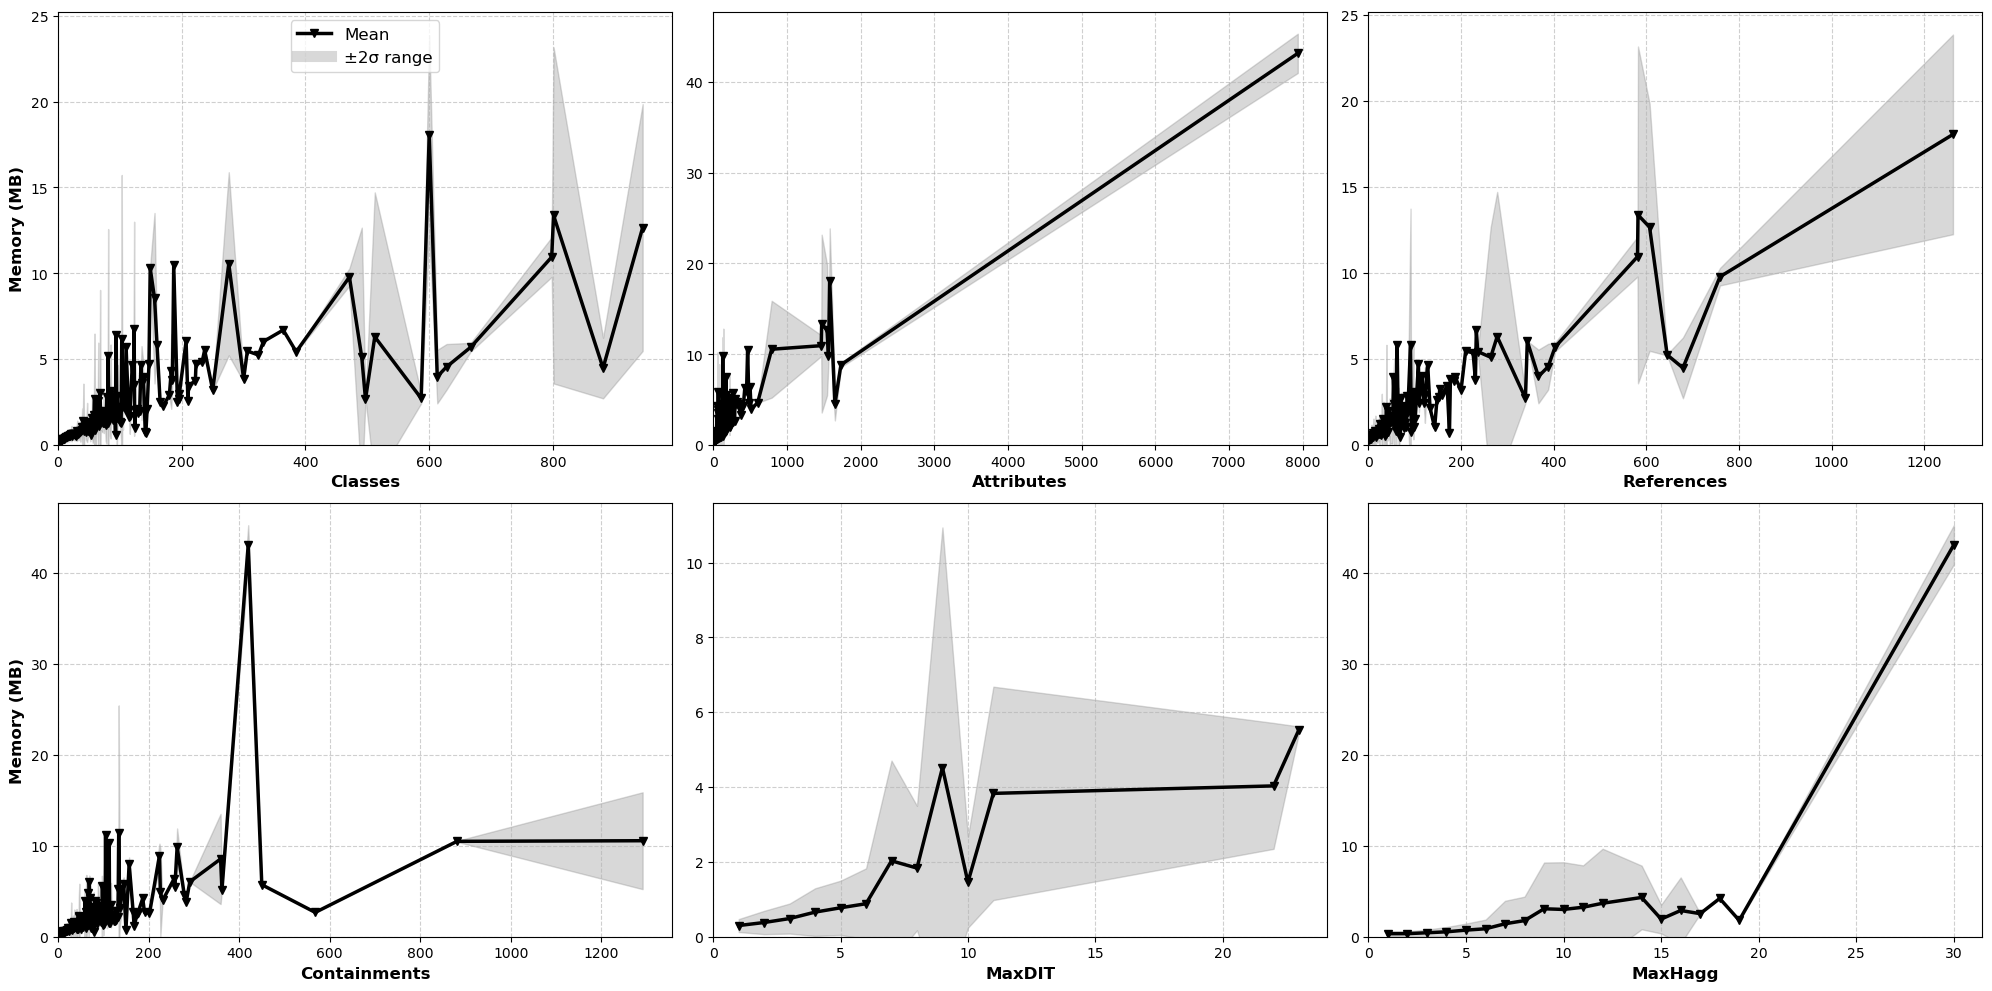

In [83]:
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import pandas as pd

for i, df in enumerate(dfs):
    df['run'] = i
runs_df = pd.concat(dfs, ignore_index=True)
combined_df = pd.merge(runs_df, valid_df, on='model', suffixes=('_run', '_model'))

props = ['classes', 'attributes', 'refs', 'containments', 'maxDIT', 'maxHagg'] 
axis_labels = {
    'classes': 'Classes',
    'attributes': 'Attributes',
    'refs': 'References',      
    'containments': 'Containments',
    'maxDIT': 'MaxDIT',       
    'maxHagg': 'MaxHagg'       
}
fig, axes = plt.subplots(2, 3, figsize=(20, 10)) 

g = 2  # number of std deviations for the band

combined_df['mem'] = combined_df['mem'] / 1024  # convert KB → MB

for idx, prop in enumerate(props):
    grouped = combined_df.groupby(prop)['mem']
    mean = grouped.apply(lambda s: remove_outliers(s).mean())
    std  = grouped.apply(lambda s: remove_outliers(s).std())
    lower = mean - g * std
    upper = mean + g * std
    cv = 100 * (std / mean)

    # Correct axis indexing
    ax = axes[idx // 3, idx % 3]

    # Plot mean line
    ax.plot(mean.index, mean.values, color='black', linewidth=2.5, label='Mean', marker='v')

    # Shaded band
    ax.fill_between(mean.index, lower, upper, color='gray', alpha=0.3, label=f'±{g}σ range')

    ax.set_xlabel(axis_labels[prop], fontsize=12, fontweight='bold')
    if idx % 3 == 0:
        ax.set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    

# Legend (on top-left subplot)
avg_line = mlines.Line2D([], [], color='black', marker='v', label='Mean', linewidth=2.5)
band_patch = mlines.Line2D([], [], color='gray', linewidth=8, alpha=0.3, label=f'±{g}σ range')
axes[0, 0].legend(handles=[avg_line, band_patch], loc='upper center', fontsize=12, frameon=True)

plt.tight_layout(pad=1)
plt.savefig("img/RQ2memavg.pdf", format='pdf', bbox_inches='tight')
plt.show()



## Considering the size of the graphs (nodes and edges)

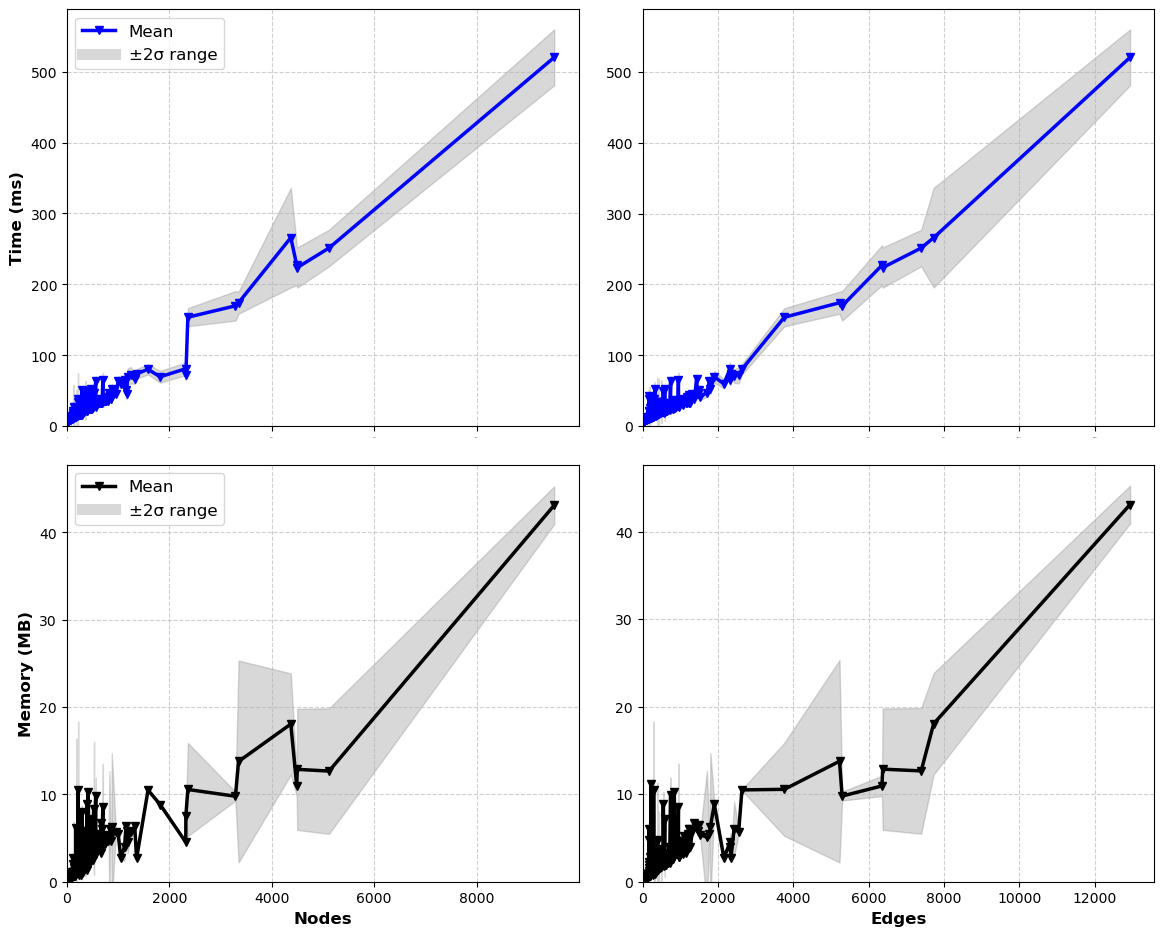

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

props = ['nodes', 'edges']
g = 2  # number of std deviations for the shaded band

fig, axes = plt.subplots(2, 2, figsize=(12, 10))   
fig.suptitle('')

 
for idx, prop in enumerate(props):
    grouped = combined_df.groupby(prop)['time']

    mean = grouped.apply(lambda s: remove_outliers(s).mean())
    std = grouped.apply(lambda s: remove_outliers(s).std())
    lower = mean - g * std
    upper = mean + g * std

    ax = axes[0, idx]

    ax.plot(mean.index, mean.values, color="blue", linewidth=2.5, label='Mean', marker='v')
    ax.fill_between(mean.index, lower, upper, color='gray', alpha=0.3, label=f'±{g}σ range')

  
    ax.set_xlabel('')

    if idx == 0:
        ax.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')

    ax.tick_params(axis='x', labelsize=0)   
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)

 
for idx, prop in enumerate(props):
    grouped = combined_df.groupby(prop)['mem']

    mean = grouped.apply(lambda s: remove_outliers(s).mean())  
    std = grouped.apply(lambda s: remove_outliers(s).std())
    lower = mean - g * std
    upper = mean + g * std

    ax = axes[1, idx]

    ax.plot(mean.index, mean.values, color="black", linewidth=2.5, label='Mean', marker='v')
    ax.fill_between(mean.index, lower, upper, color='gray', alpha=0.3, label=f'±{g}σ range')

    # Bottom row: x-axis labels
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    if idx == 0:
        ax.set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)

 
avg_line_time = mlines.Line2D([], [], color='blue', marker='v', label='Mean', linewidth=2.5)
band_patch_time = mlines.Line2D([], [], color='gray', linewidth=8, alpha=0.3, label=f'±{g}σ range')

avg_line_mem = mlines.Line2D([], [], color='black', marker='v', label='Mean', linewidth=2.5)
band_patch_mem = mlines.Line2D([], [], color='gray', linewidth=8, alpha=0.3, label=f'±{g}σ range')

axes[0, 0].legend(handles=[avg_line_time, band_patch_time], loc='upper left', fontsize=12, frameon=True)
axes[1, 0].legend(handles=[avg_line_mem, band_patch_mem], loc='upper left', fontsize=12, frameon=True)

plt.tight_layout(pad=2)
plt.savefig("img/RQ2nodesedges.pdf", format='pdf', bbox_inches='tight')
plt.show()
